## 🤖 Multi-Class, Multi-Label Emotion Classification using GoEmotions Reddit Comments Dataset

Developing a multi-class, multi-label deep neural network classifier with pre-trained embedding using Google's GoEmotions reddit comment data (full dataset) <https://github.com/google-research/google-research/tree/fd2ebbe1cdbd39f3486c0d9812b37214673c3c9d/goemotions/data>

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.utils import pad_sequences
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.initializers import he_normal, glorot_uniform
from tensorflow.keras import regularizers
import tensorflow as tf

pd.set_option('display.max_columns', None)

#### 1. Import and prepare raw data
GoEmotions full datasets <https://github.com/google-research/google-research/tree/master/goemotions/data/full_dataset>

In [7]:
## fetch raw data
df1 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv')
df2 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv')
df3 = pd.read_csv('https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv')

df = pd.concat([df1, df2, df3], axis = 0)

In [8]:
## define input X (comment texts) and output Y (28 emotion indicators)
X = df['text'].values.astype('str')
Y = df.iloc[:, 9:].values
emotions = list(df.columns[9:])

In [9]:
## split data into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
print(f"the shape of the training set (input) is: {X_train.shape}")
print(f"the shape of the training set (target) is: {Y_train.shape}\n")
print(f"the shape of the test set (input) is: {X_test.shape}")
print(f"the shape of the test set (target) is: {Y_test.shape}\n")

the shape of the training set (input) is: (168980,)
the shape of the training set (target) is: (168980, 28)

the shape of the test set (input) is: (42245,)
the shape of the test set (target) is: (42245, 28)



<Axes: title={'center': 'class label distribution (%)'}>

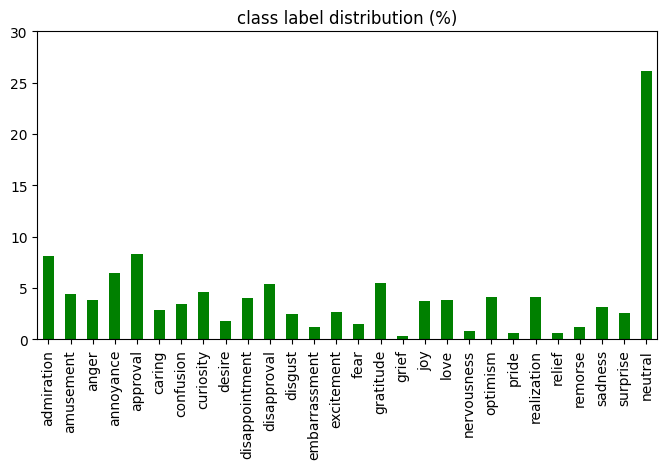

In [28]:
## examine the distribution of classes
classes = df.iloc[:, 9:].sum(axis = 0)*100.0/df.shape[0]
classes.plot(kind='bar',figsize = (8,4), title = 'class label distribution (%)', ylim=(0,30), color = 'green')

It's worth noting that the class label distribution shows an imbalanced dataset, and this should be addressed in later modeling stage. 'neutral' is the most frequent class, followed by 'approval' and 'admiration'. 'grief','relief','pride' and 'nervousness' are underrepresented classes in the dataset.

#### 2. Tokenize text data

In [32]:
## set up a tokenizer and fit training data to it
tokenizer = Tokenizer(filters='!"''“‘”#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',lower=True, oov_token='UNK')
tokenizer.fit_on_texts(X_train)
v_size = len(tokenizer.word_index)
v_size

31555

In [33]:
v = sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)
v_df = pd.DataFrame(v,columns=['word','count'])
v_df['coverage_rate'] = 100 * (v_df['count'].cumsum()/v_df['count'].sum())
v_df[v_df['coverage_rate'] > 96.5]

,word,count,coverage_rate
10542,towed,9,96.500395
10543,logs,9,96.500795
10544,blending,9,96.501194
10545,converting,9,96.501594
10546,ethereum,9,96.501993
...,...,...,...
31549,orthodoxy,1,99.999822
31550,gopher,1,99.999867
31551,concussed,1,99.999911
31552,appalachia,1,99.999956


This quick analysis shows that 10000 words from total training vocabulary account for 96.5% of word appearances in the training corpus. The 10000 words are enough for word embedding coverage.

In [34]:
## trim vocabulary to 10000 and conduct padding for each training example
max_len = 150
num_words = 10000

tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= tokenizer is 1 indexed, 0 is reserved for padding
tokenizer.word_index[tokenizer.oov_token] = num_words + 1

# turn texts into vocab vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [35]:
X_train.shape, X_test.shape

((168980, 150), (42245, 150))

#### 3. GloVe Embeddings
Utilize pre-trained GloVe 6B 300d vectors

In [37]:
## create a function to retrieve embeddings from GloVe pre-trained vectors stored in GCS
from google.cloud import storage

def create_embedding_matrix(bucket_name, blob_name, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # bucket_name = "glove-pretrained-embeddings"
    # blob_name = "glove.6B.300d.txt"
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)


    with blob.open(encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [38]:
## generate embedding matrix for our training vocabulary
embedding_dim = 300
embedding_matrix = create_embedding_matrix(bucket_name = "glove-pretrained-embeddings",
                                           blob_name = "glove.6B.300d.txt",
                                           word_index= tokenizer.word_index,
                                           embedding_dim = embedding_dim)

In [39]:
## check embedding matrix to see vocabulary embedding coverage
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9625037496250375

96.2% of our vocabulary is covered by the GloVe pre-trained embedding. This is a good coverage for us to proceed.

#### 4. Convolutional Neural Network
Texts can be thought of as one-dimensional, compared to images which are two-dimensional. 1D Convolution is applicable here.

Since we have a class imbalance issue present in data, we create custom loss function that penalizes minority class misclassifications more to account for imbalance in training. (reference https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b)

In [147]:
## custom cross-entropy loss function
# calculating class weights
positive_weights = {}
negative_weights = {}
positive_counts = {}
negative_counts = {}
for idx, c in enumerate(emotions):
    positive_counts[c] = np.count_nonzero(Y_train[:,idx]==1)
    negative_counts[c] = np.count_nonzero(Y_train[:,idx]==0)

max_positive = max(positive_counts.values())
max_negative = max(negative_counts.values())

for idx, c in enumerate(emotions):
    positive_weights[c] = max_positive/positive_counts[c]
    negative_weights[c] = max_negative/negative_counts[c]
    
print(positive_weights)
print(negative_weights)

# custom loss on one training example
def loss_fn(y_true,y_pred):
    loss = 0
    y_true = tf.cast(y_true, tf.float32)
    for idx, c in enumerate(emotions):
        loss -= (positive_weights[c]*y_true[idx]*K.log(y_pred[idx]) + negative_weights[c]*(1-y_true[idx])*K.log(1-y_pred[idx]))
        
    # loss -= (positive_weights['admiration']*y_true[0]*K.log(y_pred[0]) + negative_weights['admiration']*(1-y_true[0])*K.log(1-y_pred[0]))
    # loss -= (positive_weights['amusement']*y_true[1]*K.log(y_pred[1]) + negative_weights['amusement']*(1-y_true[1])*K.log(1-y_pred[1]))
    # loss -= (positive_weights['anger']*y_true[2]*K.log(y_pred[2]) + negative_weights['anger']*(1-y_true[2])*K.log(1-y_pred[2]))
    # loss -= (positive_weights['annoyance']*y_true[3]*K.log(y_pred[3]) + negative_weights['annoyance']*(1-y_true[3])*K.log(1-y_pred[3]))
    # loss -= (positive_weights['approval']*y_true[4]*K.log(y_pred[4]) + negative_weights['approval']*(1-y_true[4])*K.log(1-y_pred[4]))

    return loss

{'admiration': 3.218446955887714, 'amusement': 5.936919973100202, 'anger': 6.844627073964956, 'annoyance': 4.0422161172161175, 'approval': 3.1201668198204566, 'caring': 9.190297730585051, 'confusion': 7.446187584345479, 'curiosity': 5.684610431423052, 'desire': 14.548780487804878, 'disappointment': 6.567623865496206, 'disapproval': 4.851192438729531, 'disgust': 10.325380116959064, 'embarrassment': 22.440772750381292, 'excitement': 9.897085201793722, 'fear': 17.202260327357756, 'gratitude': 4.743793659322945, 'grief': 80.25636363636363, 'joy': 6.912151581584717, 'love': 6.735998779185106, 'nervousness': 30.027891156462584, 'optimism': 6.38152378198641, 'pride': 42.607142857142854, 'realization': 6.300456751355981, 'relief': 43.703960396039605, 'remorse': 21.776517020226937, 'sadness': 8.181835032437442, 'surprise': 10.013838475499092, 'neutral': 1.0}
{'admiration': 1.084790519434515, 'amusement': 1.042619703488192, 'anger': 1.0362946145658367, 'annoyance': 1.0656079969631786, 'approval'

In [148]:
K.clear_session()

In [149]:
## build a 1D convnet model using functional API
def convolutional_model(input_length, vocab_size, embedding_dim, embedding_matrix, trainable=True):
    '''
    Implements the forward propagation for the model:
    EMBEDDING -> CONV1D -> RELU -> GLOBALMAXPOOL -> DENSE
    
    Arguments:
    input_txt -- input text dataset, of shape (input_length)

    Returns:
    model -- TF Keras model
    
    '''
    input_txt = tf.keras.Input(shape = input_length)
    EMBEDDING = tf.keras.layers.Embedding(input_dim = vocab_size,
                                         output_dim = embedding_dim,
                                         input_length = input_length,
                                         weights = [embedding_matrix],
                                         trainable = trainable)(input_txt)
    
    A1 = tf.keras.layers.Conv1D(filters = 256, kernel_size = 3, activation = 'relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.1), kernel_initializer=glorot_uniform())(EMBEDDING)
    D1 = tf.keras.layers.Dropout(0.3)(A1)
    P1 = tf.keras.layers.GlobalMaxPooling1D()(D1)
    
    # Z2 = tf.keras.layers.Conv1D(filters = 1024, kernel_size = 3, strides = 1, padding = 'valid', kernel_regularizer=regularizers.L2(l2=0.05))(P1)
    # B2 = tf.keras.layers.BatchNormalization()(Z2)
    # A2 = tf.keras.layers.ReLU()(B2)
    # D2 = tf.keras.layers.Dropout(0.3)(A2)
    # P2 = tf.keras.layers.MaxPool1D()(D2)
    
    # F = tf.keras.layers.Flatten()(P1)
    F = tf.keras.layers.Dense(units = 100, activation = 'relu')(P1)
    output = tf.keras.layers.Dense(units = 28, activation = 'sigmoid')(F)
    
    model = tf.keras.Model(inputs = input_txt, outputs = output)
    return model

In [150]:
## compile and define model evaluation metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def alpha_evaluation(y_true, y_pred):
    """
    This function implements alpha-evaluation score for evaluating multi-label classification tasks.
    Score reference - https://www.rose-hulman.edu/~boutell/publications/boutell04PRmultilabel.pdf
    """    
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    alpha = K.constant(1, 'float32')
    beta = K.constant(0.75, 'float32')
    gamma = K.constant(1, 'float32')
    
    tp = K.cast(K.sum(y_true * y_pred), 'float32')
    fp = K.cast(K.sum(neg_y_true * y_pred), 'float32')
    fn = K.cast(K.sum(y_true * neg_y_pred), 'float32')
    
    score = 1 - ((beta * fn + gamma * fp) / (fn+ fp +tp + K.epsilon()))

    return score


conv_model = convolutional_model(max_len, vocab_size, embedding_dim, embedding_matrix, trainable=True)
conv_model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001), loss=loss_fn,
                 metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(), f1_m, alpha_evaluation]
                  )

conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 300)          3000300   
                                                                 
 conv1d (Conv1D)             (None, 148, 256)          230656    
                                                                 
 dropout (Dropout)           (None, 148, 256)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               25700     
                                                             

In [151]:
## model training
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
         ModelCheckpoint(filepath='best_conv_model.h5', monitor='val_loss', save_best_only=True)]

history = conv_model.fit(X_train, Y_train, epochs=50, verbose=True, validation_data=(X_test, Y_test), batch_size=100, shuffle=True, callbacks = callbacks)

Epoch 1/50
1690/1690 [==============================] - 34s 18ms/step - loss: 41.3077 - binary_accuracy: 0.8542 - auc: 0.7583 - f1_m: 0.2229 - alpha_evaluation: 0.1621 - val_loss: 32.9041 - val_binary_accuracy: 0.8747 - val_auc: 0.8071 - val_f1_m: 0.2638 - val_alpha_evaluation: 0.1857
Epoch 2/50
1690/1690 [==============================] - 29s 17ms/step - loss: 28.4844 - binary_accuracy: 0.8781 - auc: 0.8250 - f1_m: 0.2763 - alpha_evaluation: 0.1933 - val_loss: 25.8747 - val_binary_accuracy: 0.8811 - val_auc: 0.8454 - val_f1_m: 0.2941 - val_alpha_evaluation: 0.2031
Epoch 3/50
1690/1690 [==============================] - 29s 17ms/step - loss: 24.0123 - binary_accuracy: 0.8761 - auc: 0.8500 - f1_m: 0.2926 - alpha_evaluation: 0.1995 - val_loss: 23.3633 - val_binary_accuracy: 0.8705 - val_auc: 0.8617 - val_f1_m: 0.2959 - val_alpha_evaluation: 0.1979
Epoch 4/50
1690/1690 [==============================] - 30s 18ms/step - loss: 22.1489 - binary_accuracy: 0.8746 - auc: 0.8618 - f1_m: 0.2996 -

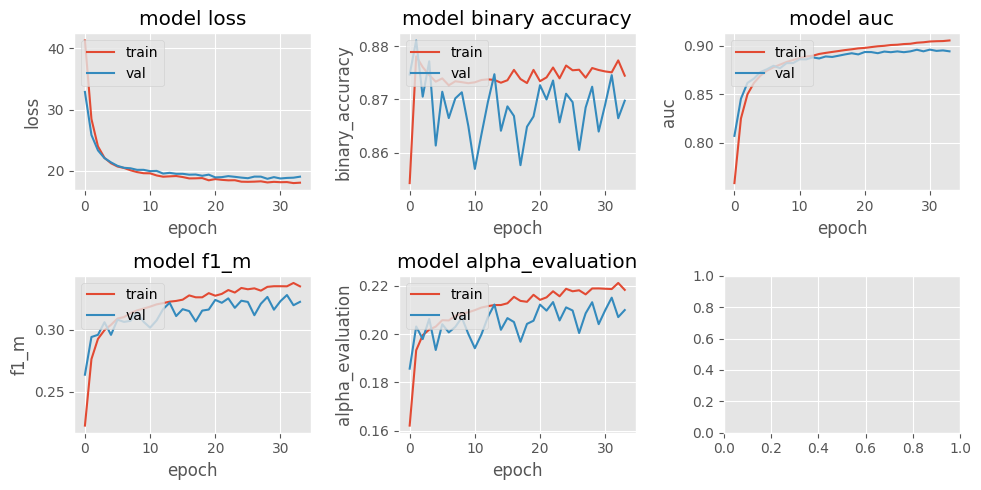

In [155]:
## training/validation plots
plt.style.use('ggplot')
figure, axis = plt.subplots(2, 3, figsize=(10, 5))

axis[0, 0].plot(history.history['loss'])
axis[0, 0].plot(history.history['val_loss'])
axis[0, 0].set_title("model loss")
axis[0, 0].set_ylabel('loss')
axis[0, 0].set_xlabel('epoch')
axis[0, 0].legend(['train', 'val'], loc='upper left')

axis[0, 1].plot(history.history['binary_accuracy'])
axis[0, 1].plot(history.history['val_binary_accuracy'])
axis[0, 1].set_title("model binary accuracy")
axis[0, 1].set_ylabel('binary_accuracy')
axis[0, 1].set_xlabel('epoch')
axis[0, 1].legend(['train', 'val'], loc='upper left')

axis[0, 2].plot(history.history['auc'])
axis[0, 2].plot(history.history['val_auc'])
axis[0, 2].set_title("model auc")
axis[0, 2].set_ylabel('auc')
axis[0, 2].set_xlabel('epoch')
axis[0, 2].legend(['train', 'val'], loc='upper left')

axis[1, 0].plot(history.history['f1_m'])
axis[1, 0].plot(history.history['val_f1_m'])
axis[1, 0].set_title("model f1_m")
axis[1, 0].set_ylabel('f1_m')
axis[1, 0].set_xlabel('epoch')
axis[1, 0].legend(['train', 'val'], loc='upper left')

axis[1, 1].plot(history.history['alpha_evaluation'])
axis[1, 1].plot(history.history['val_alpha_evaluation'])
axis[1, 1].set_title("model alpha_evaluation")
axis[1, 1].set_ylabel('alpha_evaluation')
axis[1, 1].set_xlabel('epoch')
axis[1, 1].legend(['train', 'val'], loc='upper left')

plt.tight_layout()

# def plot_history(history):
#     f1 = history.history['f1_m']
#     val_f1 = history.history['val_f1_m']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     x = range(1, len(f1) + 1)

#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(x, f1, 'b', label='Training f1')
#     plt.plot(x, val_f1, 'r', label='Validation f1')
#     plt.title('Training and validation f1')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.legend()

# plot_history(history)

In [171]:
## evaluate further on test data and set probability threshold for predicting emotion labels
Y_pred = conv_model.predict(X_test)
thresholds=[0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
for val in thresholds:
    pred=Y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(Y_test, pred, average='micro')
    recall = recall_score(Y_test, pred, average='micro')
    f1 = f1_score(Y_test, pred, average='micro')
    alpha = alpha_evaluation(Y_test, pred)
   
    print("Threshold: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, Alpha: {:.4f}".format(val, precision, recall, f1, alpha))

1321/1321 [==============================] - 2s 2ms/step
Threshold: 0.1000, Precision: 0.0597, Recall: 0.9872, F1-measure: 0.1126, Alpha: 0.0599
Threshold: 0.2000, Precision: 0.0871, Recall: 0.9496, F1-measure: 0.1596, Alpha: 0.0879
Threshold: 0.2500, Precision: 0.1026, Recall: 0.9241, F1-measure: 0.1848, Alpha: 0.1039
Threshold: 0.3000, Precision: 0.1194, Recall: 0.8947, F1-measure: 0.2107, Alpha: 0.1212
Threshold: 0.3500, Precision: 0.1376, Recall: 0.8599, F1-measure: 0.2373, Alpha: 0.1401
Threshold: 0.4000, Precision: 0.1581, Recall: 0.8236, F1-measure: 0.2653, Alpha: 0.1611
Threshold: 0.4500, Precision: 0.1809, Recall: 0.7811, F1-measure: 0.2938, Alpha: 0.1842
Threshold: 0.5000, Precision: 0.2066, Recall: 0.7320, F1-measure: 0.3223, Alpha: 0.2097
Threshold: 0.5500, Precision: 0.2362, Recall: 0.6781, F1-measure: 0.3503, Alpha: 0.2376
Threshold: 0.6000, Precision: 0.2700, Recall: 0.6196, F1-measure: 0.3761, Alpha: 0.2672
Threshold: 0.6500, Precision: 0.3090, Recall: 0.5551, F1-measur

We could separately determine the best threshold for each individual emotion label, but for simplicity here we just use a global threshold which seems to have a best value of 0.75.

In [176]:
## use best threshold value and evaluate each emotion label prediction results
precisions = []
recalls = []
f1_scores = []
alphas = []
threshold = 0.75
for i in range(0,28):
    emotion_prediction = Y_pred[:,i]
    emotion_prediction[emotion_prediction>=threshold]=1
    emotion_prediction[emotion_prediction<threshold]=0
    emotion_test = Y_test[:,i]
    precision = precision_score(emotion_test, emotion_prediction)
    recall = recall_score(emotion_test, emotion_prediction)
    f1 = f1_score(emotion_test, emotion_prediction)
    alpha = alpha_evaluation(emotion_test, emotion_prediction)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    alphas.append(alpha)
    # print("Emotion: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, Alpha: {:.4f}".format(emotions[i], precision, recall, f1, alpha))
    
score_df = pd.DataFrame({'Variable':emotions,
                         'Precision':precisions,
                         'Recall':recalls,
                         'F1-Score':f1_scores,
                         'Alpha-Score':alphas})

score_df

,Variable,Precision,Recall,F1-Score,Alpha-Score
0,admiration,0.527288,0.568501,0.547119,"tf.Tensor(0.44803178, shape=(), dtype=float32)"
1,amusement,0.497715,0.782320,0.608378,"tf.Tensor(0.46758258, shape=(), dtype=float32)"
2,anger,0.313349,0.409174,0.354907,"tf.Tensor(0.29361498, shape=(), dtype=float32)"
3,annoyance,0.259850,0.193106,0.221561,"tf.Tensor(0.2547226, shape=(), dtype=float32)"
4,approval,0.366667,0.095019,0.150926,"tf.Tensor(0.27597082, shape=(), dtype=float32)"
5,caring,0.296259,0.244983,0.268192,"tf.Tensor(0.27418077, shape=(), dtype=float32)"
6,confusion,0.267880,0.143955,0.187273,"tf.Tensor(0.25689566, shape=(), dtype=float32)"
7,curiosity,0.311492,0.310846,0.311169,"tf.Tensor(0.28637344, shape=(), dtype=float32)"
8,desire,0.351020,0.329502,0.339921,"tf.Tensor(0.30892855, shape=(), dtype=float32)"
9,disappointment,0.319540,0.079519,0.127348,"tf.Tensor(0.26479942, shape=(), dtype=float32)"


##### Save model to GCS bucket

In [177]:
from tensorflow.python.lib.io import file_io
import os
from google.cloud import storage

# Save model locally
conv_model.save('cnn_model.h5')

# Copy cnn_model.h5 over to Google Cloud Storage
model_directory = 'gs://goemotions-cnn-classifier'
storage_path = os.path.join(model_directory, 'cnn_model.h5')
blob = storage.blob.Blob.from_string(storage_path, 
                                    client=storage.Client(project=''))
blob.upload_from_filename('cnn_model.h5')